# Kaggle Titanic Survival Prediction
_**Using Scikit-learn to Predict Whether a Passenger on the Titanic Survived**_

---

## Contents

1. [Introduction](#Introduction)
1. [Dependancies](#Dependancies)
1. [Data Cleaning](#Data-Cleaning)
1. [EDA](#EDA)
1. [Feature Selection and Engineering](#Feature-Selection-and-Engineering)
1. [Data Preprocessing](#Data-Preprocessing)
1. [Model Building](#Model-Building)
1. [Make Predictions](#Make-Predictions)

**`Note`**: We would normally split into Train, Test, and Validation data sets between Data Cleaning and EDA, but Kaggle provides the data presplit.

---

## Introduction

The dataset variables (columns) are as follows:
* **`PassengerId`**
* **`Pclass`** - Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)
* **`Name`** -- Name of passenger
* **`Sex`** - Sex of passenger
* **`Age`** - Age in years
* **`SibSp`** - # of siblings / spouses aboard the Titanic
* **`Parch`** - # of parents / children aboard the Titanic
* **`Ticket`** - Ticket number
* **`Fare`** - Passenger fare
* **`Cabin`** - Cabin number
* **`Embarked`** - Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)
* **`Survived`** - boolean for whether the passenger survived or not. (1 = Survived, 0 = Did not survive) **(target)**

The data has some small notes listed on Kaggle:
```
Variable Notes
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.
```

This is Kaggle's canonical example of a binary classification problem. We will attempt to predict whether a passenger on the Titanic survived using the above variables as our potential predictors.

# Dependancies

In [58]:
import itertools
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
from utils import annotate_count_plot
import seaborn as sns

In [59]:
pd.set_option("display.max_columns", 20)

train = pd.read_csv("training.csv")
print(f"Head of training data")
display(train)

print(f"Quick and Dirty summary of training data")
display(train.describe())

print(f"Data types")
dtypes = pd.DataFrame(train.dtypes)
dtypes.columns = ["Data Type"]
display(dtypes)

Head of training data


PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ...    ...   
886                              Montvila, Rev. Juozas    male  27.0      0   
887                       Graham, Miss. Margaret Edith  female  19.0      0   
888           Johnston, Miss. Catherine Helen "Carrie"  female   NaN      1   
889                              Behr, Mr. Karl Howell    male  26.0      0   
890                                Dooley, Mr. Patrick    male  32.0      0   

     Parch            Ticket     Fare Cabin Embarked  
0        0         A/5 21171   7.2500   NaN        S  
1        0          PC 17599  71.2833   C85        C  
2        0  STON/O2. 3101282   7.9250   NaN        S  
3        0            113803  53.1000  C123        S  
4        0            373450   8.0500   NaN        S  
..     ...               ...      ...   ...      ...  
886      0            211536  13.0000   NaN        S  
887      0            112053  30.0000   B42        S  
888      2        W./C. 6607  23.4500   NaN        S  
889      0            111369  30.0000  C148        C  
890      0            370376   7.7500   NaN        Q  

[891 rows x 12 columns]

Quick and Dirty summary of training data


PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

Data types


Data Type
PassengerId     int64
Survived        int64
Pclass          int64
Name           object
Sex            object
Age           float64
SibSp           int64
Parch           int64
Ticket         object
Fare          float64
Cabin          object
Embarked       object

# Data Cleaning
---
Here we will look for any data quality issues and fix them.

**We have to be certain that we do the same transformations on our training data and test data**, *but do them independently* -- we want to avoid data leakage.

**For example**: if we scale our data before the split, our test data can skew the summary statistics. In other words, we are including information about the test set in our model which is an issue.
* If the test data contains a maximum value and we use `MinMaxScaler`, then we will scale the training set based on knowlegde from the test set.

This is also important for real world applications because our test data will be *future* data making our scaling in the example above invalid (we do not have infomation on future data).


One thing we can do is convert `Pclass` to a categorical variable since it is currently treated as a numeric (`int64`)

In [60]:
# Convert Pclass to String
train["Pclass"] = train["Pclass"].astype(str)

# EDA

In [61]:
# Pandas profile reports provides a very nice quick and dirty solution for EDA.
profile = ProfileReport(train, title="Pandas Profiling Report")
# Save the report as an HTML file in the 
profile.to_file("generated_reports/profiling_report.html")
# View the report
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Summary Findings and Ideas to Explore
---

##### Summary Findings
We can see that 61.6% of the passengers from the training set did not survive. Over half of the passengers were in 3rd class. 

There are 5 numeric variables and 7 categorical variables.

We will likely want to do some feature engineering on the categorical predictors with high `cardinality` to reduce the possibilities and/or create more meaningful groupings.

**Looking at the distribution of the numeric variables:**
* `Age` is somewhat normally distributed with a slight skew in the very young age range (0-2)

* `SibSp` has a heavy right skew (68.2% of passengers had 0 siblings or spouses on board)

* `Parch` also has a heavy right skew (76.1% of passengers had 0 parents or children on board)

* `Fare` is also right skewed, but not as heavily as `SibSp` or `Parch`. It appears more normal than these 2
  * It is not surprised to see the right skew, given that *majority* of the passengers are in 3rd class
  * Interestingly, 15 passengers had a $0 fare ==> What could be the reason for this ?

* `PassengerId` is not really anything of value since it is just a *primary key* used to represent a unique passenger

To account for the skewed distributions, we will want to center and scale our numeric variables before we pass them to our model.


**Looking at the categorical variables:**
* `Pclass` most are 3rd class

* `Name` ==> What if anything can we extrapolate from this variable ? Does it contain information we can use to help our model ?
  * Is there an interaction with information in `Name` with another variable ? Maybe having a prominent title and more money means you had a better chance of survival ?

* `Sex` ==> Approximately $\frac{2}{3}$ of the passengers from the training set are Males

* `Ticket` ==> There are a lot of distinct values here, can we reduces this variable into fewer more meaningful options ?

* `Cabin` has $\frac{3}{4}$ missing values, should we consider dropping this variable ?
  * Is there any other variable that we can use to "fill in the gaps" for `Cabin` ?
  * Will imputation impact our model's ability to generalize ?

* `Embarked` ~ $\frac{3}{4}$ of passengers embarked from Southampton (`S`). Does the passenger origin have an impact on survival rates ?
  * Knowing that some passengers were using the Titanic to migrate to the US and Canada, does the data give an arguement of potential discrimination ?
    * ie, maybe there are more passengers from a certain culture that embarked from Southampton or elsewhere ?

* `Survived` is our target variable, 61.6% did not survive


There are missing values for the following columns in order of most `NULL` values:
1. Cabin (77.6% Missing)
2. Age (19.9% Missing)
3. Embarked (0.2% Missing)

We can compare model performance when we handle these missing values using *imputation* vs removing the columns will null values. Since so many values of Cabin are missing, we may opt to drop the column from our model entirely to avoid making too many assumptions with imputation.

From the Spearman's p correlation matrix, we can see that `Survived` and `Pclass` are negatively correlated, as well as `Survived` and `Fare`. Additionally, there is a high correlation between `Fare` and `Pclass` as we would expect 1st class to be more costly. If we use a linear model, or another model sensitive to [*multicolinearity*](https://en.wikipedia.org/wiki/Multicollinearity), we may need consider removal of one of the highly correlated predictors (dimensionality reduction).

---
#### Ideas to Explore
* Did the wealthy passengers have a better chance of surviving ? (High fare or a Pclass)

* Did passengers with children and/or spouses have a lower survival rate ?
  * Could have been preoccupied with trying to save their family over their own safety ?
  
* How did the age of the passenger affect survival rates ?

* How did the Sex of the passenger affect survival rates ?
  * Were women and children prioritized ?

* Since there were multiple decks on the boat, did the people staying near the main top deck have higher survival rates ? If so, can we use the data we have to find the deck a passenger was staying on ?
  * Does `Ticket` or `Cabin` have any information about the positioning of the passenger ?

* Some of the name prefixes indicate a sterotypical "high" social status (*master*, *Dr.*, etc.). Do these individuals have a higher survival rate ?

* Did a particular origin have higher or lower survival rates than other origin ?
  * *C = Cherbourg (Ireland), Q = Queenstown (France), S = Southampton (England)*


#### EDA Continued (Categorical variable relationships with `Survived`)
---

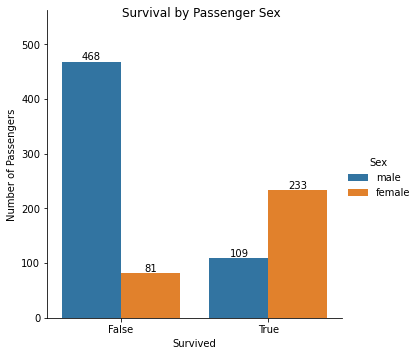

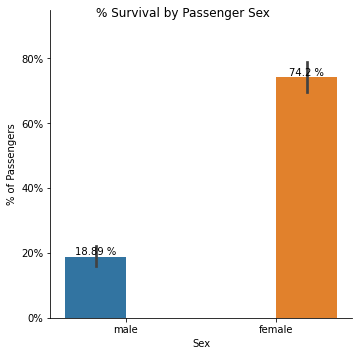

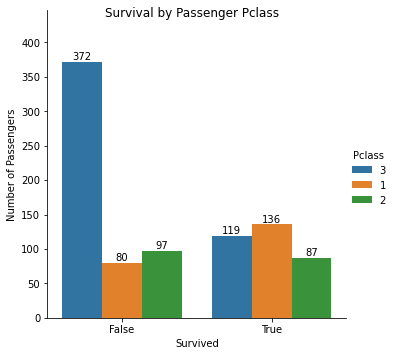

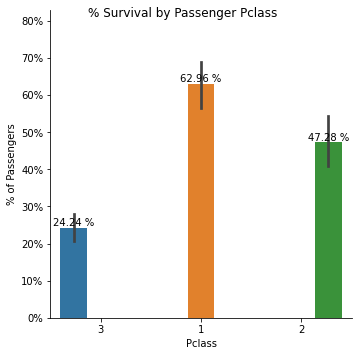

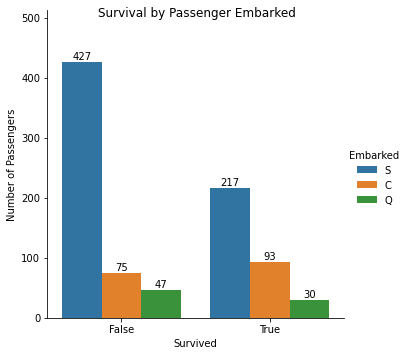

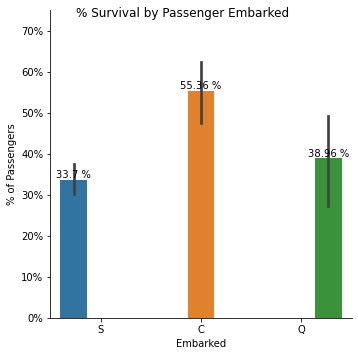

In [62]:
# Compare each of the following categorical variables relationship to Survived
small_categoricals = ["Sex", "Pclass", "Embarked"]
for category in small_categoricals:
    g = sns.catplot(data=train, x="Survived", hue=category, kind="count")
    g.set_ylabels("Number of Passengers")
    g.fig.suptitle(f"Survival by Passenger {category}")
    g.set_xticklabels(["False", "True"])
    annotate_count_plot(g)
    plt.show()
    g = sns.catplot(data=train, x=category, y="Survived", hue=category, kind="bar")
    for ax in g.axes.flat:
        ax.yaxis.set_major_formatter(PercentFormatter(1))
    g.set_ylabels("% of Passengers")
    g.fig.suptitle(f"% Survival by Passenger {category}")
    annotate_count_plot(g, kind="percent")
    plt.show()

We can see that a lot more female passengers survived compared to males. 

The majority of 1st class passengers survived, almost half of the 2nd class passengers survived, and a significantly higher proportion of 3rd class passengers did not survive. This could be due to a prioritization of affluent individuals, or positioning on the boat, or some combination of the two.

Survival rates was very similar across all origins for the `Embarked` variable with Cherbourg having slightly higher survival rates.

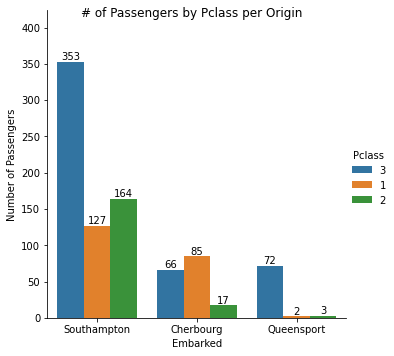

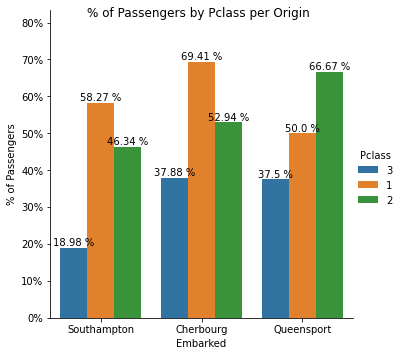

In [63]:
# How many 1st, 2nd, and 3rd class citizens from each origin ?
g = sns.catplot(data=train, x="Embarked", hue="Pclass", kind="count")
g.set_ylabels("Number of Passengers")
g.fig.suptitle(f"# of Passengers by Pclass per Origin")
g.set_xticklabels(["Southampton", "Cherbourg", "Queensport"])
annotate_count_plot(g)
plt.show()
g = sns.catplot(data=train, x="Embarked", y="Survived", hue="Pclass", kind="bar", ci=False)
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(PercentFormatter(1))
g.set_ylabels("% of Passengers")
g.fig.suptitle(f"% of Passengers by Pclass per Origin")
g.set_xticklabels(["Southampton", "Cherbourg", "Queensport"])
annotate_count_plot(g, kind="percent")
plt.show()

Passengers embarking from Cherbourg had higher proportions of 1st class passengers

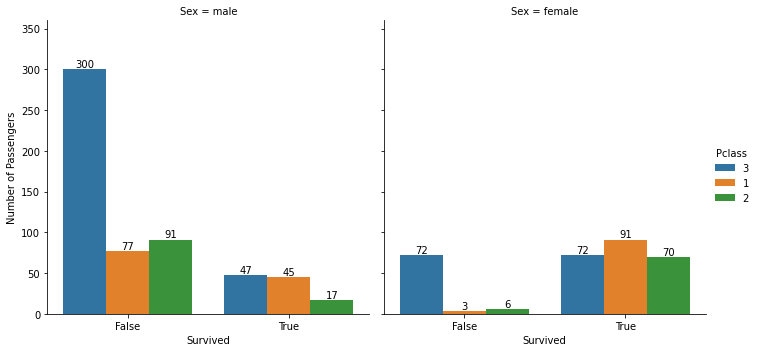

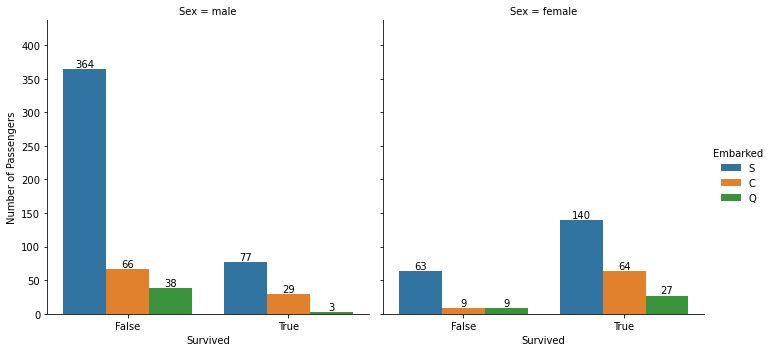

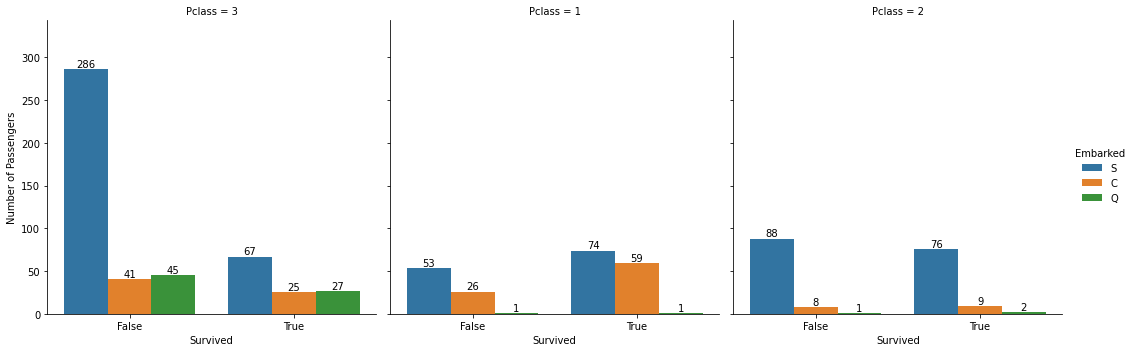

In [64]:
# Categorical Interactions and their relationship with Survived
all_combinations = itertools.combinations(["Sex", "Pclass", "Embarked"], 2)

small_categoricals = ["Sex", "Pclass", "Embarked"]
for combination in all_combinations:
    g = sns.catplot(data=train, x="Survived", col=combination[0], hue=combination[1], kind="count")
    g.set_ylabels("Number of Passengers")
    g.set_xticklabels(["False", "True"])
    # Annotate the bars with the count at the top of each bar
    annotate_count_plot(g)

A lot more females in 1st and 2nd class survived compared to their 3rd class counterparts. Showing the interaction between `Pclass` and `Sex` highlights how much more likely a 1st and 2nd class passenger were to survive, especially when `Sex = female`.

The split of `Embarked` is even across males and females.

The interaction between `Plcass` and `Embarked` does not seem to affect number of survivers differently, Survival is similar across all socio-economic classes and origins. This is evidence against a bias on passenger survival based on the origin of the passenger when accounting for the passenger's socio-economic class.


#### EDA Continued (Numeric variable relationships with `Survived`)
---

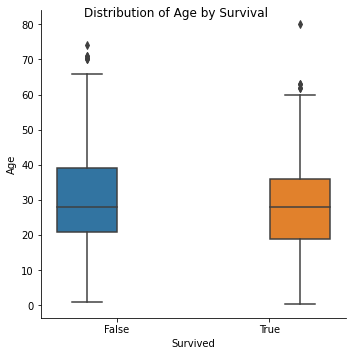

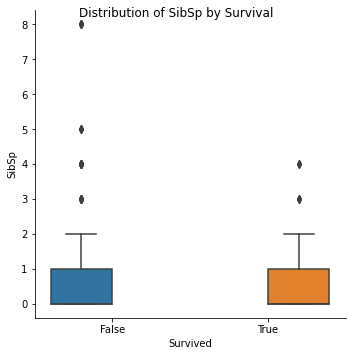

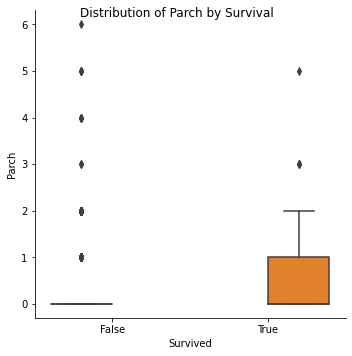

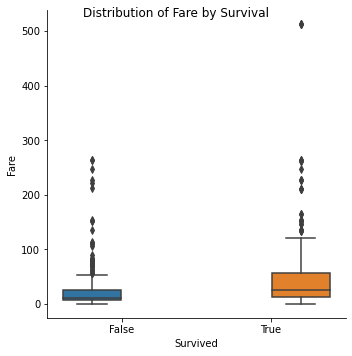

In [65]:
# All unique combinations of Numeric Variables and Survived
# all_combinations = itertools.combinations(train.drop(columns="PassengerId").select_dtypes(include=['number']), 2)
# print(f"All possible unique 2 way combinations of a numeric variable and Survived\n{list(all_combinations)}")
for numeric in train.drop(columns=["Survived", "PassengerId"]).select_dtypes(include=['number']).columns.values:
    g = sns.catplot(data=train, y=numeric, x="Survived", hue="Survived", kind="box")
    g.fig.suptitle(f"Distribution of {numeric} by Survival")
    g.set_xticklabels(["False", "True"])

Since the `Parch` and `SibSp` numeric variables are discrete, the boxplots created are not as informative compared to a continuous variable. 

We will need to consider a different plot like a count plot to see the relationship between `Parch` and `SibSp` and survival.

Age by itself does not seem to be a major factor on survival.

It looks like people with higher ticket fares had overall higher Survivals, but the results are very hard to see because of the scale of the `Fare` column. We can apply a log transform and replot to get a better understanding on how `Fare` is related to `Survived`.

/Users/nathanjones/opt/anaconda3/envs/jupyter-notebook-env/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


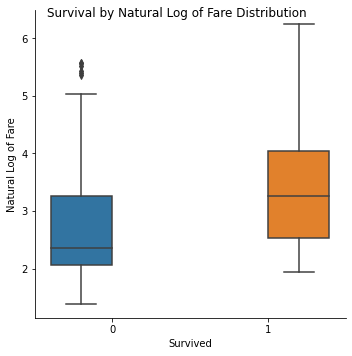

In [66]:
train["logFare"] = np.log(train["Fare"])
g = sns.catplot(data=train, y="logFare", x="Survived", hue="Survived", kind="box")
g.set_ylabels("Natural Log of Fare")
g.fig.suptitle(f"Survival by Natural Log of Fare Distribution")
train.drop(columns=["logFare"], inplace=True)

The scaling makes it easier to see the trend we identified in the original data -- you were more likely to have survived if you had a higher ticket fare !

##### Countplots of SibSp and Parch vs. Survived

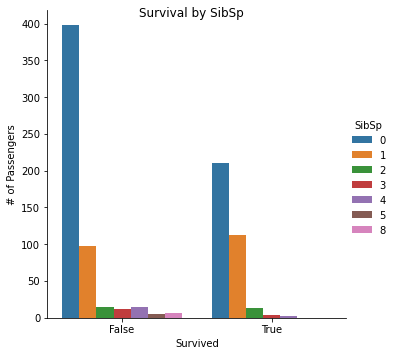

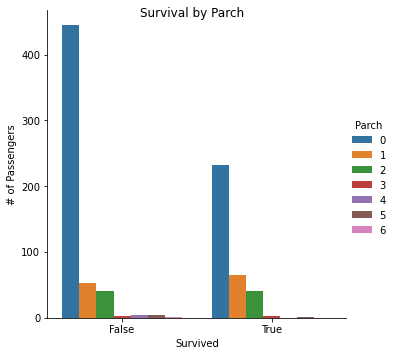

In [67]:
for var in ["SibSp", "Parch"]:
    g = sns.catplot(data=train, x="Survived", hue=var, kind="count")
    g.set_xticklabels(["False", "True"])
    g.set_ylabels("# of Passengers")
    g.fig.suptitle(f"Survival by {var}")
    # annotate_count_plot(g)

Passengers with 3+ siblings and spouses had slightly lower survival rates, but otherwise the graphs seem fairly similar.

Passengers with 4+ parents and children had slightly lower survival rates, but otherwise the graphs seem fairly similar.

We can look at the percentages as opposed to raw counts to see this a bit more clearly. Another interesting idea to explore is by creating a categorical variable that combines both `SibSp` and `Parch` as a way of determining the family size of a given passenger. It seems rational to assume that larger families had a lower chance of surviving, as they may have operated under an "all or none" mentality

In [68]:
train.groupby(by=["SibSp"]).count().reset_index()[["SibSp", "Survived"]]

SibSp  Survived
0      0       608
1      1       209
2      2        28
3      3        16
4      4        18
5      5         5
6      8         7

##### Survival Percentages per value of SibSp and Parch

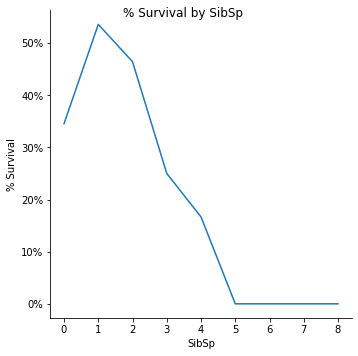

Number of Observations per Group Shown in the Graphs Above:



SibSp  Survived
0      0       608
1      1       209
2      2        28
3      3        16
4      4        18
5      5         5
6      8         7

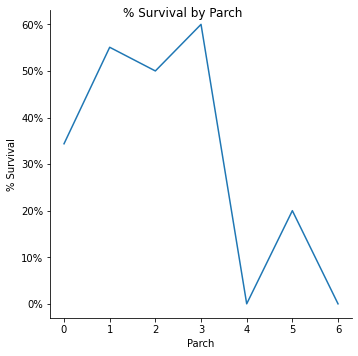

Number of Observations per Group Shown in the Graphs Above:



Parch  Survived
0      0       678
1      1       118
2      2        80
3      3         5
4      4         4
5      5         5
6      6         1

In [69]:
# Survival % across SibSp
sibling_spouse_survival = train.groupby(by=["SibSp"]).mean()["Survived"].reset_index().rename(columns={"Survived":"survival_proportion"})
g = sns.relplot(data=sibling_spouse_survival, x="SibSp", y="survival_proportion", kind="line")
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(PercentFormatter(1))
g.set_ylabels("% Survival")
g.fig.suptitle("% Survival by SibSp")
plt.show()

# Value Counts across SibSp
print("Number of Observations per Group Shown in the Graphs Above:\n")
display(train.groupby(by=["SibSp"]).count().reset_index()[["SibSp", "Survived"]])

# Survival % across Parch
parent_child_survival = train.groupby(by=["Parch"]).mean()["Survived"].reset_index().rename(columns={"Survived":"survival_proportion"})
g = sns.relplot(data=parent_child_survival, x="Parch", y="survival_proportion", kind="line")
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(PercentFormatter(1))
g.set_ylabels("% Survival")
g.fig.suptitle("% Survival by Parch")
plt.show()

print("Number of Observations per Group Shown in the Graphs Above:\n")
# Value Counts across Parch
display(train.groupby(by=["Parch"]).count().reset_index()[["Parch", "Survived"]])

In general, passengers with more siblings and spouses had a lower percentage of Survival, although there are not enough observations with high values for `SibSp` to say this with much confidence.

Similarily, passengers with more parents and children had a lower percentage of Survival, although there are not enough observations with high values for `Parch` to say this with much confidence.

##### Survival Amongst Family Sizes

Here we can create some custom bins to bucket passenger family sizes. We will use the sum of `SibSp` and `Parch` to determine family size ($Family Size = SibSp + Parch$)

Dataframe with new columns


PassengerId  Survived Pclass  \
0            1         0      3   
1            2         1      1   
2            3         1      3   
3            4         1      1   
4            5         0      3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked family_size_category  \
0      0         A/5 21171   7.2500   NaN        S         Small Family   
1      0          PC 17599  71.2833   C85        C         Small Family   
2      0  STON/O2. 3101282   7.9250   NaN        S            No Family   
3      0            113803  53.1000  C123        S         Small Family   
4      0            373450   8.0500   NaN        S            No Family   

   family_size  
0            1  
1            1  
2            0  
3            1  
4            0

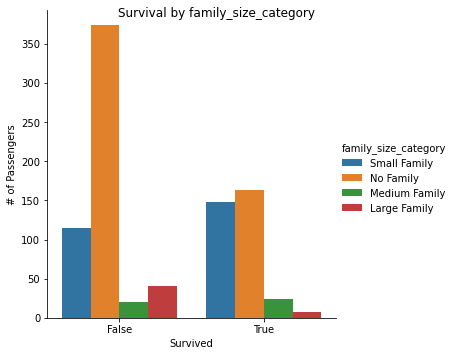

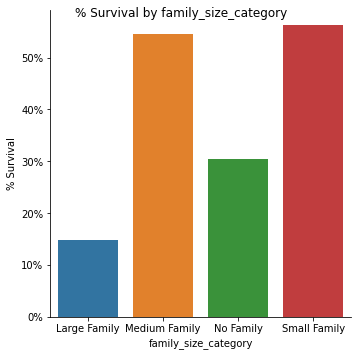

Number of Observations per Group Shown in the Graphs Above:



family_size_category  Survived
0         Large Family        47
1        Medium Family        44
2            No Family       537
3         Small Family       263

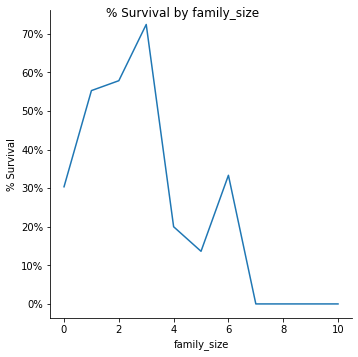

Number of Observations per Group Shown in the Graphs Above:



family_size  Survived
0            0       537
1            1       161
2            2       102
3            3        29
4            4        15
5            5        22
6            6        12
7            7         6
8           10         7

In [70]:
# Create categories for family size
def categorize_family_size(data):
    if data["SibSp"] + data["Parch"] < 1:
        return "No Family"
    elif data["SibSp"] + data["Parch"] >= 1 and data["SibSp"] + data["Parch"] < 3:
        return "Small Family"
    elif data["SibSp"] + data["Parch"] >= 3 and data["SibSp"] + data["Parch"] < 5:
        return "Medium Family"
    elif data["SibSp"] + data["Parch"] >= 5:
        return "Large Family"
train["family_size_category"] = train.apply(categorize_family_size, axis=1)
train["family_size"] = train["SibSp"] + train["Parch"]
print("Dataframe with new columns")
display(train.head())

# Graph Survival by Family Size Category
g = sns.catplot(data=train, x="Survived", hue="family_size_category", kind="count")
g.set_xticklabels(["False", "True"])
g.set_ylabels("# of Passengers")
g.fig.suptitle("Survival by family_size_category")
plt.show()

# Survival % across Family Size Category
family_size_category_survival = train.groupby(by=["family_size_category"]).mean()["Survived"].reset_index().rename(columns={"Survived":"survival_proportion"})
g = sns.catplot(data=family_size_category_survival, x="family_size_category", y="survival_proportion", kind="bar")
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(PercentFormatter(1))
g.set_ylabels("% Survival")
g.fig.suptitle("% Survival by family_size_category")
plt.show()

print("Number of Observations per Group Shown in the Graphs Above:\n")
# Value Counts across Family Size Category
display(train.groupby(by=["family_size_category"]).count().reset_index()[["family_size_category", "Survived"]])

# Survival % across Family Size
family_size_survival = train.groupby(by=["family_size"]).mean()["Survived"].reset_index().rename(columns={"Survived":"survival_proportion"})
g = sns.relplot(data=family_size_survival, x="family_size", y="survival_proportion", kind="line")
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(PercentFormatter(1))
g.set_ylabels("% Survival")
g.fig.suptitle("% Survival by family_size")
plt.show()

print("Number of Observations per Group Shown in the Graphs Above:\n")
# Value Counts across Family Size
display(train.groupby(by=["family_size"]).count().reset_index()[["family_size", "Survived"]])

# Drop family_size and family_size_category (We can add in later under feature engineering if it's useful)
train.drop(columns=["family_size", "family_size_category"], inplace=True)

It looks like there may be some validity to our hypothesis that larger familes had a lower chance of survival. Large families had a significantly lower survival rate than the other groups. Surprisingly, Medium size families had much higher survival rates than passengers with no family.

There may be a family size "Sweet Spot" where having *some* family onboard was beneficial to surviving (Looking out for each other).

##### Survival Percentages among Prestigious Titles

The `Name` column contains potentially useful information about the passengers "prestige". We can extract the prefixes and consolidate via some text cleaning.

In [71]:
# Extract the name prefixes
name_prefixes = train["Name"].str.split(',').str[1].str.split('.').str[0].str.replace(' ', '')
train["name_prefix"] = name_prefixes
unqiue_name_prefixes = name_prefixes.unique()
unqiue_name_prefixes.sort()
print(f"All unique name prefixes\n{unqiue_name_prefixes}")

# Define remapping / consolidate prefixes
def consolidate_prefixes(data):
    prefix = data["name_prefix"]
    if prefix in ["Mr"] and data["Sex"] == "male":
        return "non_prestigious_man"
    
    elif prefix in ["Capt", "Col", "Don", "Dr", "Jonkheer", "Major", "Master", "Rev", "Sir"] and data["Sex"] == "male":
        return "prestigious_man"
    
    elif prefix in ["Mlle", "Miss", "Mme", "Mrs", "Ms"] and data["Sex"] == "female":
        return "non_prestigious_woman"
    
    elif prefix in ["Lady", "Dr", "theCountess"] and data["Sex"] == "female":
        return "prestigious_woman"
    
    else:
        return 'error_left_uncategorized'
# Create a new column with the consolidated prefixes
train["consolidated_name_prefix"] = train.apply(consolidate_prefixes, axis=1)
# Check that we didn't miss anything
train.groupby(by=["consolidated_name_prefix"]).count()[["PassengerId"]].sort_values(by="PassengerId", ascending=False)

All unique name prefixes
['Capt' 'Col' 'Don' 'Dr' 'Jonkheer' 'Lady' 'Major' 'Master' 'Miss' 'Mlle'
 'Mme' 'Mr' 'Mrs' 'Ms' 'Rev' 'Sir' 'theCountess']


PassengerId
consolidated_name_prefix             
non_prestigious_man               517
non_prestigious_woman             311
prestigious_man                    60
prestigious_woman                   3

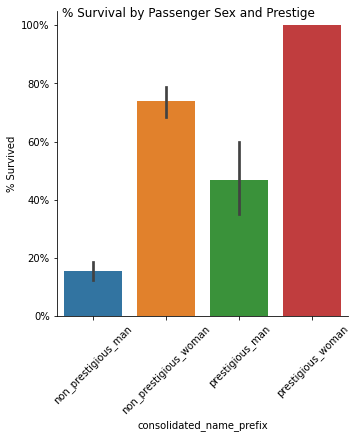

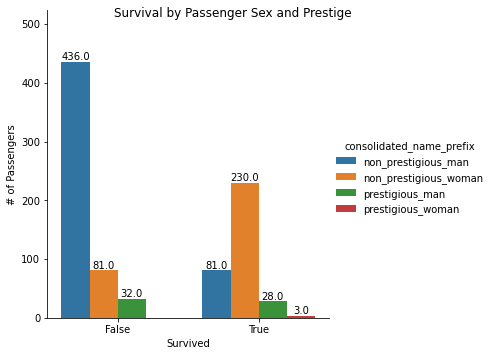

In [72]:
g = sns.catplot(data=train, y="Survived", x="consolidated_name_prefix", kind="bar")
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(PercentFormatter(1))
g.set_ylabels("% Survived")
g.fig.suptitle(f"% Survival by Passenger Sex and Prestige")
plt.xticks(rotation = 45)
plt.show()
g = sns.catplot(data=train, x="Survived", hue="consolidated_name_prefix", kind="count")
annotate_count_plot(g)
g.set_ylabels("# of Passengers")
g.set_xticklabels(["False", "True"])
g.fig.suptitle(f"Survival by Passenger Sex and Prestige")
train.drop(columns=["consolidated_name_prefix"], inplace=True)

The categories created are not very informative for female passengers since the we on only had 3 passengers in the `prestigious_woman` category. Similarly there were only 60 `prestigious_man`. Interestingly, `prestigious_man` did have higher survival rates than men overall, indicating a possible relationship between being a man with a presitigious title and surviving. This is hard to say with a lot of certainty though because we only have 60 passengers in the `prestigious_man` category.

Due to the severity of imbalance in the categories, we will instead collapse the name prefixes into the following instead, `PrestigiousMr`, `Mr`, `Mrs`, `Ms`

In [73]:
# Change consolidated_name_prefix
def consolidate_prefixes(data):
    prefix = data["name_prefix"]
    if prefix in ["Mr"] and data["Sex"] == "male":
        return "Mr"
    
    elif prefix in ["Capt", "Col", "Don", "Dr", "Jonkheer", "Major", "Master", "Rev", "Sir"] and data["Sex"] == "male":
        return "PrestigiousMr"
    
    elif prefix in ["Miss", "Ms", "Mlle"] and data["Sex"] == "female":
        return "Miss"
    
    elif prefix in ["Dona", "Mme", "Mrs", "Lady", "Dr", "theCountess"] and data["Sex"] == "female":
        return "Mrs"
    
    else:
        return 'error_left_uncategorized'
# Create a new column with the consolidated prefixes
train["consolidated_name_prefix"] = train.apply(consolidate_prefixes, axis=1)
# Check that we didn't miss anything
train.groupby(by=["consolidated_name_prefix"]).count()[["PassengerId"]].sort_values(by="PassengerId", ascending=False)
# train.drop(columns=["name_prefix"], inplace=True)

PassengerId
consolidated_name_prefix             
Mr                                517
Miss                              185
Mrs                               129
PrestigiousMr                      60

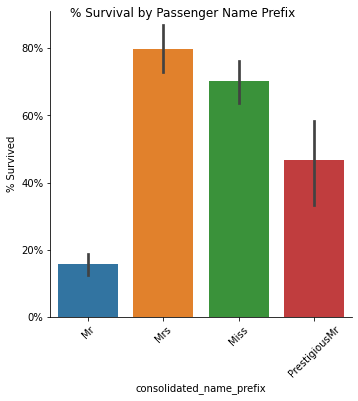

Text(0.5, 0.98, 'Survival by Passenger Name Prefix')

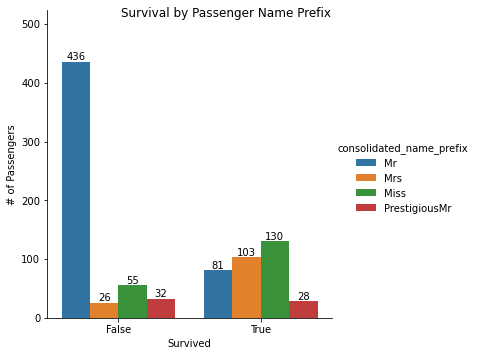

In [74]:
g = sns.catplot(data=train, y="Survived", x="consolidated_name_prefix", kind="bar")
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(PercentFormatter(1))
g.set_ylabels("% Survived")
g.fig.suptitle(f"% Survival by Passenger Name Prefix")
plt.xticks(rotation = 45)
plt.show()
g = sns.catplot(data=train, x="Survived", hue="consolidated_name_prefix", kind="count")
annotate_count_plot(g)
g.set_ylabels("# of Passengers")
g.set_xticklabels(["False", "True"])
g.fig.suptitle(f"Survival by Passenger Name Prefix")

##### Survival by Consolidated Name Prefixes and logFare Interaction

/Users/nathanjones/opt/anaconda3/envs/jupyter-notebook-env/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


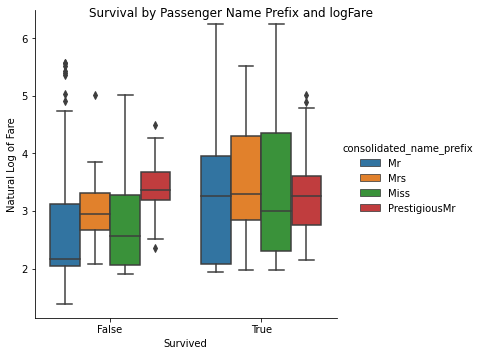

In [75]:
train["logFare"] = np.log(train["Fare"])
g = sns.catplot(data=train, y="logFare", x="Survived", hue="consolidated_name_prefix", kind="box")
g.set_ylabels("Natural Log of Fare")
g.set_xticklabels(["False", "True"])
g.fig.suptitle(f"Survival by Passenger Name Prefix and logFare")
train.drop(columns=["logFare"], inplace=True)
train.drop(columns=["consolidated_name_prefix"], inplace=True)

These new categories are much more balanced. Let's continue by looking at the other 2 high cardinality categorical variables `Cabin` and `Ticket` to see if we can reduce them into meaningful categories for our model.

In [76]:
print(f"Number of Missing Values for Cabin and Ticket columns:\n{train[['Cabin', 'Ticket']].isnull().sum()}")

Number of Missing Values for Cabin and Ticket columns:
Cabin     687
Ticket      0
dtype: int64


`Cabin` has a lot of missing values, so we should test whether imputation or removing the column is better for model performance. Nevertheless, we can still do some exploration with `Cabin`.

After some reading on the [Titanic Wikipedia page](https://en.wikipedia.org/wiki/Titanic), the ship had 9 decks (A-G), and it seems we could extract this deck information from the `Cabin` variable.

In [77]:
import re
print(f"All unique entries for Cabin:\n{train['Cabin'].unique()}")
# Extract the first leading capital letter as the Deck
train["deck"] = train["Cabin"].str.extract(r'(^[A-Z])')
train.groupby(by=["deck"], dropna=False).count()[["PassengerId"]].sort_values(by="PassengerId", ascending=False)
train.drop(columns=["deck"], inplace=True)

All unique entries for Cabin:
[nan 'C85' 'C123' 'E46' 'G6' 'C103' 'D56' 'A6' 'C23 C25 C27' 'B78' 'D33'
 'B30' 'C52' 'B28' 'C83' 'F33' 'F G73' 'E31' 'A5' 'D10 D12' 'D26' 'C110'
 'B58 B60' 'E101' 'F E69' 'D47' 'B86' 'F2' 'C2' 'E33' 'B19' 'A7' 'C49'
 'F4' 'A32' 'B4' 'B80' 'A31' 'D36' 'D15' 'C93' 'C78' 'D35' 'C87' 'B77'
 'E67' 'B94' 'C125' 'C99' 'C118' 'D7' 'A19' 'B49' 'D' 'C22 C26' 'C106'
 'C65' 'E36' 'C54' 'B57 B59 B63 B66' 'C7' 'E34' 'C32' 'B18' 'C124' 'C91'
 'E40' 'T' 'C128' 'D37' 'B35' 'E50' 'C82' 'B96 B98' 'E10' 'E44' 'A34'
 'C104' 'C111' 'C92' 'E38' 'D21' 'E12' 'E63' 'A14' 'B37' 'C30' 'D20' 'B79'
 'E25' 'D46' 'B73' 'C95' 'B38' 'B39' 'B22' 'C86' 'C70' 'A16' 'C101' 'C68'
 'A10' 'E68' 'B41' 'A20' 'D19' 'D50' 'D9' 'A23' 'B50' 'A26' 'D48' 'E58'
 'C126' 'B71' 'B51 B53 B55' 'D49' 'B5' 'B20' 'F G63' 'C62 C64' 'E24' 'C90'
 'C45' 'E8' 'B101' 'D45' 'C46' 'D30' 'E121' 'D11' 'E77' 'F38' 'B3' 'D6'
 'B82 B84' 'D17' 'A36' 'B102' 'B69' 'E49' 'C47' 'D28' 'E17' 'A24' 'C50'
 'B42' 'C148']


Most of the known passenger decks were C and B, but there are so many missing values this could be misleading. We will handle this later on by creating a new `Cabin` label, `N`, to represent missing values.

In [78]:
# Ticket information
print(f"There are {len(train['Ticket'].unique())} unqiue values for ticket.")
print(f"Preview of the unique values:\n{train['Ticket'].unique()[0:100]}")

There are 681 unqiue values for ticket.
Preview of the unique values:
['A/5 21171' 'PC 17599' 'STON/O2. 3101282' '113803' '373450' '330877'
 '17463' '349909' '347742' '237736' 'PP 9549' '113783' 'A/5. 2151'
 '347082' '350406' '248706' '382652' '244373' '345763' '2649' '239865'
 '248698' '330923' '113788' '347077' '2631' '19950' '330959' '349216'
 'PC 17601' 'PC 17569' '335677' 'C.A. 24579' 'PC 17604' '113789' '2677'
 'A./5. 2152' '345764' '2651' '7546' '11668' '349253' 'SC/Paris 2123'
 '330958' 'S.C./A.4. 23567' '370371' '14311' '2662' '349237' '3101295'
 'A/4. 39886' 'PC 17572' '2926' '113509' '19947' 'C.A. 31026' '2697'
 'C.A. 34651' 'CA 2144' '2669' '113572' '36973' '347088' 'PC 17605' '2661'
 'C.A. 29395' 'S.P. 3464' '3101281' '315151' 'C.A. 33111' 'S.O.C. 14879'
 '2680' '1601' '348123' '349208' '374746' '248738' '364516' '345767'
 '345779' '330932' '113059' 'SO/C 14885' '3101278' 'W./C. 6608'
 'SOTON/OQ 392086' '343275' '343276' '347466' 'W.E.P. 5734' 'C.A. 2315'
 '364500' '374910

For the sake of saving some time, we won't dive into trying to extract meaning from the `Ticket` column. For now, we will simply drop the column because of the amount of unique values and no easily discernable pattern (**although you should experiment more in a real world modeling scenario**).

We can always come back to this later and try to create some features from `Ticket` and increase our predictive power.

# Feature Selection and Engineering

We will create new features based on the ones that we explored in the EDA section.

In [79]:
# 1. User defined functions for feature engineering
def engineer_features(data):
    data["family_size"] = data["SibSp"] + data["Parch"]
    data["consolidated_name_prefix"] = data.apply(consolidate_prefixes, axis=1)
    data["deck"] = data["Cabin"].str.extract(r'(^[A-Z])').fillna('N')
    return data

engineer_features(train)

PassengerId  Survived Pclass  \
0              1         0      3   
1              2         1      1   
2              3         1      3   
3              4         1      1   
4              5         0      3   
..           ...       ...    ...   
886          887         0      2   
887          888         1      1   
888          889         0      3   
889          890         1      1   
890          891         0      3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ...    ...   
886                              Montvila, Rev. Juozas    male  27.0      0   
887                       Graham, Miss. Margaret Edith  female  19.0      0   
888           Johnston, Miss. Catherine Helen "Carrie"  female   NaN      1   
889                              Behr, Mr. Karl Howell    male  26.0      0   
890                                Dooley, Mr. Patrick    male  32.0      0   

     Parch            Ticket     Fare Cabin Embarked name_prefix  family_size  \
0        0         A/5 21171   7.2500   NaN        S          Mr            1   
1        0          PC 17599  71.2833   C85        C         Mrs            1   
2        0  STON/O2. 3101282   7.9250   NaN        S        Miss            0   
3        0            113803  53.1000  C123        S         Mrs            1   
4        0            373450   8.0500   NaN        S          Mr            0   
..     ...               ...      ...   ...      ...         ...          ...   
886      0            211536  13.0000   NaN        S         Rev            0   
887      0            112053  30.0000   B42        S        Miss            0   
888      2        W./C. 6607  23.4500   NaN        S        Miss            3   
889      0            111369  30.0000  C148        C          Mr            0   
890      0            370376   7.7500   NaN        Q          Mr            0   

    consolidated_name_prefix deck  
0                         Mr    N  
1                        Mrs    C  
2                       Miss    N  
3                        Mrs    C  
4                         Mr    N  
..                       ...  ...  
886            PrestigiousMr    N  
887                     Miss    B  
888                     Miss    N  
889                       Mr    C  
890                       Mr    N  

[891 rows x 16 columns]

Now that we have created some new features we will do the following:

1. Apply transformations to our columns based on their type `categorical` vs. `numeric` 

1. Tie it all together using an `sklearn` `Pipeline`


# Data Preprocessing

In [80]:
# Defining a SciKit Learn Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score

# Isolate Passenger ID to join later
train_passenger_ids = train["PassengerId"]
# Drop unused columns
train.drop(columns=["Ticket", "PassengerId", "Cabin", "name_prefix"], inplace=True)
# 2. Apply transformations based on data type
# Scale Numerical Data and OneHotEncode Categorical Data
numeric_features = train.drop(columns = ["Survived"]).select_dtypes(include="number").columns.values
numeric_transformer = Pipeline(
    steps=[
        ("numeric_imputer", SimpleImputer(strategy="median")), 
        ("scaler", StandardScaler())
        ]
)

categorical_features = train.select_dtypes(exclude="number").columns.values
categorical_transformer = Pipeline(
    steps=[
        ("categorical_imputer", SimpleImputer(strategy="most_frequent")), 
        ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
        ("num", numeric_transformer, numeric_features),
    ]
)

In [81]:
X_test = pd.read_csv("test.csv")
test_passenger_ids = X_test[["PassengerId"]]
name_prefixes = X_test["Name"].str.split(',').str[1].str.split('.').str[0].str.replace(' ', '')
X_test["name_prefix"] = name_prefixes
engineer_features(X_test)
X_test.drop(columns=["Ticket", "PassengerId", "Cabin"], inplace=True)
X_test.drop(columns=["name_prefix"], inplace=True)
X_test

Pclass                                          Name     Sex   Age  \
0         3                              Kelly, Mr. James    male  34.5   
1         3              Wilkes, Mrs. James (Ellen Needs)  female  47.0   
2         2                     Myles, Mr. Thomas Francis    male  62.0   
3         3                              Wirz, Mr. Albert    male  27.0   
4         3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female  22.0   
..      ...                                           ...     ...   ...   
413       3                            Spector, Mr. Woolf    male   NaN   
414       1                  Oliva y Ocana, Dona. Fermina  female  39.0   
415       3                  Saether, Mr. Simon Sivertsen    male  38.5   
416       3                           Ware, Mr. Frederick    male   NaN   
417       3                      Peter, Master. Michael J    male   NaN   

     SibSp  Parch      Fare Embarked  family_size consolidated_name_prefix  \
0        0      0    7.8292        Q            0                       Mr   
1        1      0    7.0000        S            1                      Mrs   
2        0      0    9.6875        Q            0                       Mr   
3        0      0    8.6625        S            0                       Mr   
4        1      1   12.2875        S            2                      Mrs   
..     ...    ...       ...      ...          ...                      ...   
413      0      0    8.0500        S            0                       Mr   
414      0      0  108.9000        C            0                      Mrs   
415      0      0    7.2500        S            0                       Mr   
416      0      0    8.0500        S            0                       Mr   
417      1      1   22.3583        C            2            PrestigiousMr   

    deck  
0      N  
1      N  
2      N  
3      N  
4      N  
..   ...  
413    N  
414    C  
415    N  
416    N  
417    N  

[418 rows x 11 columns]

In [82]:
# 3. Tie it Setup the pipeline steps: steps
steps = [
         ('preprocessor', preprocessor), # ColumnTransformer was used to scale numeric data and one hot encode categorical data (bundled into single preprocessor step)
         ('random_forest_classifier', RandomForestClassifier(random_state=10))
         ]

# Create the pipeline: pipeline 
pipeline = Pipeline(steps)

# Specify the hyperparameter space
# print(RandomForestClassifier().get_params().keys()) # Show the hyperparameters that we can tune
# Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
parameters = {
            # 'random_forest_classifier__n_estimators': n_estimators,
            'random_forest_classifier__max_features': max_features,
            # 'random_forest_classifier__max_depth': max_depth,
            'random_forest_classifier__min_samples_split': min_samples_split,
            'random_forest_classifier__min_samples_leaf': min_samples_leaf,
            'random_forest_classifier__bootstrap': bootstrap
               }


# scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}
# Create the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(pipeline
                     , parameters
                     , cv = 3
                     # , scoring= scoring
                     , refit = True
                     , return_train_score=True
                    )
# Split X and y for training set
X_train = train.drop(columns=["Survived"])
y_train = train["Survived"]
# Fit to the training set to find optimal parameters
gm_cv.fit(X_train, y_train)
# CV Results
results = gm_cv.cv_results_
results = pd.DataFrame(results)
# Make predictions on the Test Set
y_pred = gm_cv.predict(X_test)

In [83]:
print(f"Cross Validation Results\n")
display(results)
print(f"Predictions\n")
display(y_pred)

Cross Validation Results



mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.135896      0.002808         0.012838        0.000344   
1        0.121396      0.001985         0.012548        0.000331   
2        0.117682      0.002885         0.013138        0.000201   
3        0.076724      0.001656         0.009884        0.000077   
4        0.076233      0.000676         0.010313        0.000462   
5        0.076621      0.001247         0.010186        0.000332   
6        0.076490      0.001234         0.009823        0.000147   
7        0.075596      0.001052         0.009654        0.000128   
8        0.075935      0.002656         0.010295        0.000187   
9        0.133347      0.002586         0.013226        0.000426   
10       0.123134      0.002114         0.013242        0.000735   
11       0.115127      0.000692         0.012834        0.000721   
12       0.074430      0.000364         0.009456        0.000150   
13       0.073858      0.000212         0.009471        0.000152   
14       0.073742      0.000830         0.009507        0.000338   
15       0.076369      0.001308         0.009962        0.000567   
16       0.073507      0.000099         0.009419        0.000104   
17       0.073694      0.000459         0.009445        0.000120   
18       0.140268      0.003254         0.013587        0.000898   
19       0.127167      0.004217         0.013076        0.000336   
20       0.116083      0.004182         0.013169        0.000299   
21       0.058266      0.002729         0.009856        0.000538   
22       0.057400      0.000800         0.009966        0.000312   
23       0.057375      0.000926         0.010037        0.000236   
24       0.056376      0.000434         0.010310        0.000747   
25       0.056776      0.000163         0.009897        0.000425   
26       0.055858      0.000281         0.009791        0.000297   
27       0.143807      0.001595         0.013716        0.000317   
28       0.129770      0.003580         0.013753        0.000743   
29       0.114592      0.002372         0.012811        0.000215   
30       0.055891      0.000682         0.009354        0.000073   
31       0.056545      0.000996         0.009549        0.000242   
32       0.055565      0.001010         0.009456        0.000254   
33       0.055550      0.000549         0.009411        0.000121   
34       0.055352      0.000535         0.009374        0.000114   
35       0.054652      0.000332         0.009145        0.000055   

   param_random_forest_classifier__bootstrap  \
0                                       True   
1                                       True   
2                                       True   
3                                       True   
4                                       True   
5                                       True   
6                                       True   
7                                       True   
8                                       True   
9                                       True   
10                                      True   
11                                      True   
12                                      True   
13                                      True   
14                                      True   
15                                      True   
16                                      True   
17                                      True   
18                                     False   
19                                     False   
20                                     False   
21                                     False   
22                                     False   
23                                     False   
24                                     False   
25                                     False   
26                                     False   
27                                     False   
28                                     False   
29                                     False   

Predictions



array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

Finally we can add our predictions back to the original dataframe for submission on Kaggle

In [84]:
test_passenger_ids["Survived"] = y_pred
test_passenger_ids.to_csv("submission.csv", index=False)

/var/folders/_x/pygw_dc547s30m9tt7vvh5v00000gp/T/ipykernel_44881/821328975.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_passenger_ids["Survived"] = y_pred
